🐱 Cat Sound Classification using Machine Learning & ANN

This notebook demonstrates how to build a machine learning pipeline for cat sound classification — specifically, classifying different states or behaviors of a cat (e.g., purring, meowing for attention, hissing) based on their audio recordings.

We'll walk through the following steps:

📌 Objectives

    Preprocess cat audio recordings to improve quality and consistency.

    Extract relevant features that capture the unique acoustic properties of cat sounds.

    Train a machine learning model (Artificial Neural Network - ANN) for classification.

    Evaluate model performance using accuracy and classification metrics.

🛠️ Techniques Used

🔉 Audio Preprocessing

    Trimming: Remove silence and background noise from the beginning and end of the audio.

    Normalization: Ensure audio levels are consistent across files.

    Resampling: Convert all recordings to a fixed sampling rate (e.g., 16kHz).

    Padding/Truncating: Standardize the duration of input samples.

📊 Feature Extraction

We extract a variety of acoustic features that capture cat vocalization patterns:

    MFCCs (Mel-Frequency Cepstral Coefficients): Capture timbral characteristics of meows, purrs, and hisses.

    Spectral Centroid: Indicates where the "center of mass" of sound frequencies lies (e.g., higher for a meow, lower for a purr).

    Spectral Rolloff: Frequency below which a certain % of the signal’s energy is contained.

    Zero-Crossing Rate: Useful for detecting sharp hissing sounds or trills.

    RMS Energy: Represents the loudness and energy of the cat’s vocalization.

🧠 Model

We use an Artificial Neural Network (ANN) to classify audio samples. The ANN takes the extracted features as input and learns to distinguish between different categories of cat sounds (e.g., content purr vs. urgent meow vs. defensive hiss).

📈 Evaluation

The final ml model is evaluated using:

    Accuracy

    Precision, Recall, and F1-Score

    Confusion Matrix

    Training vs. Validation Loss/Accuracy curves to check model learning performance

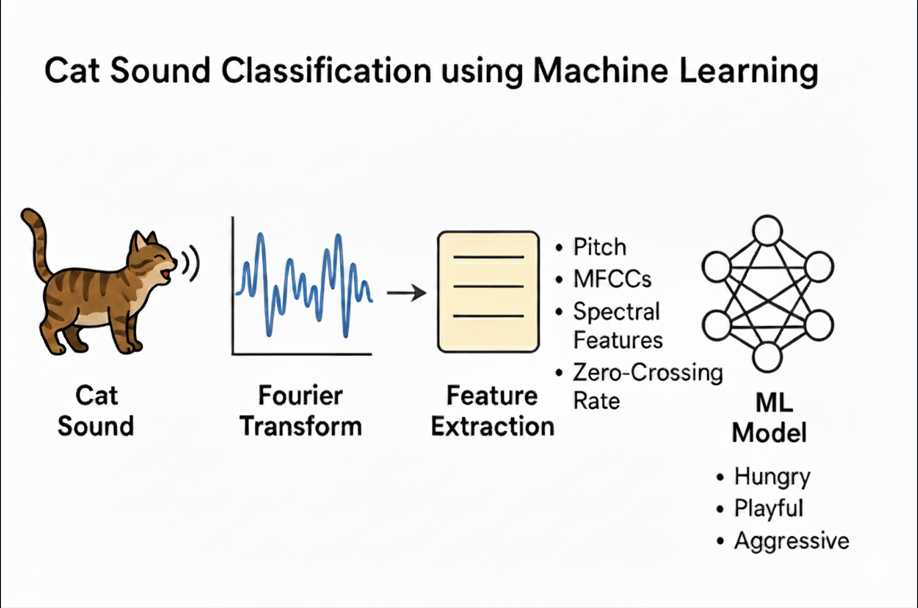

# **import libraries**

In [ ]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.effects
import noisereduce as nr
import IPython.display as ipd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import concurrent.futures
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style('darkgrid')

# **get sample voice**

In [8]:
sample=r"C:\Users\user\OneDrive\Desktop\cat\NAYA_DATA_AUG1X\Audio\Angry\car_extcoll0103_aug1(1).mp3"

In [9]:
x, sr = librosa.load(sample)

In [10]:
ipd.Audio(sample)

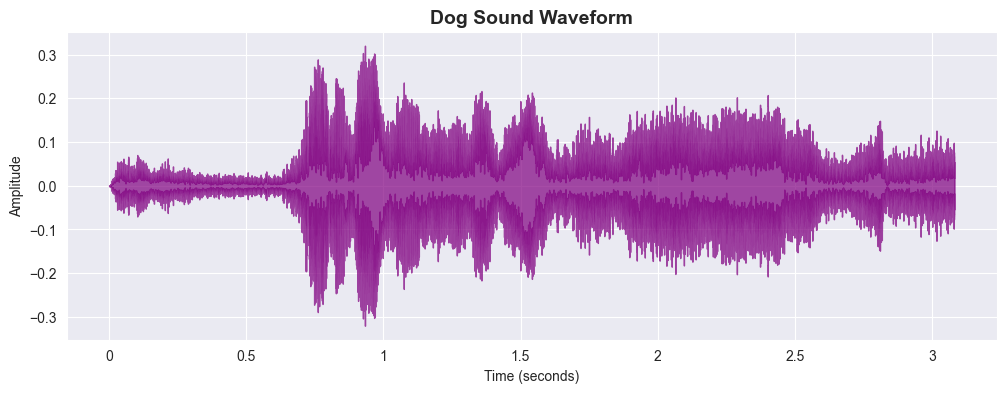

In [11]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(x, sr=sr, alpha=0.7, color="purple")
plt.title("Dog Sound Waveform", fontsize=14, weight="bold")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

## **The graph shows equal fluctuations between positive and negative values, meaning that it is neither too sharp nor too soft, with the sound calming down in the middle.**

# **Audio preprocessing**

In [12]:
SAMPLE_RATE = 16000 
DURATION = 3
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

## **I keep all files unified and compatible with the model.**

In [13]:
def PreprocessAudio(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        
        y, _ = librosa.effects.trim(y)
        
       
        y = nr.reduce_noise(y=y, sr=sr)
        
        
        y = librosa.util.normalize(y)

       
        if len(y) < SAMPLES_PER_TRACK:
            y = np.pad(y, (0, SAMPLES_PER_TRACK - len(y)))
        else:
            y = y[:SAMPLES_PER_TRACK]

        return y, sr
    except Exception as error:
        print(f"Failed to process '{file_path}': {error}")
        return None, None

## **Full code for Audio preprocessing  with a review at the end. If the length is less than 3 seconds, fill it with zeros. If it is more, decrease it.**

# **Feature Extraction**

In [14]:
def ExtractAudioFeatures(file_path):
    audio_signal, sample_rate = PreprocessAudio(file_path)
    if audio_signal is None:
        return None

    n_fft = 2048  
    hop_length = 512  
    
    mfcc = librosa.feature.mfcc(y=audio_signal, sr=sample_rate, n_mfcc=13, hop_length=hop_length, n_fft=n_fft)
    mfcc_mean = np.mean(mfcc, axis=1)

    rolloff = librosa.feature.spectral_rolloff(y=audio_signal, sr=sample_rate, hop_length=hop_length, n_fft=n_fft)[0]
    rolloff_mean = np.mean(rolloff)

    zcr = librosa.feature.zero_crossing_rate(y=audio_signal, hop_length=hop_length)[0]
    zcr_mean = np.mean(zcr)

    centroid = librosa.feature.spectral_centroid(y=audio_signal, sr=sample_rate, hop_length=hop_length, n_fft=n_fft)[0]
    centroid_mean = np.mean(centroid)

    rms = librosa.feature.rms(y=audio_signal, hop_length=hop_length)[0]
    rms_mean = np.mean(rms)

    combined_features = np.hstack([
        mfcc_mean,
        rolloff_mean,
        zcr_mean,
        centroid_mean,
        rms_mean
    ])

    return combined_features

## **n_fft: Number of samples per analysis window. Example: 2048 → about 128 ms at 16kHz.**

## **hop_length: Step size between windows. Example: 512 → about 32 ms at 16kHz.**

## **Overlap: Because hop_length < n_fft, windows overlap (here 75% overlap)**

## **Here I have selected the top 13 MFCCs in the variance as if you were doing PCA so that the number of columns is not too many.**

In [19]:
angry=r"C:\Users\user\OneDrive\Desktop\cat\NAYA_DATA_AUG1X\Audio\Angry"
happy=r"C:\Users\user\OneDrive\Desktop\cat\NAYA_DATA_AUG1X\Audio\Happy"
Stressed=r"C:\Users\user\OneDrive\Desktop\cat\NAYA_DATA_AUG1X\Audio\Stressed"
Sad=r"C:\Users\user\OneDrive\Desktop\cat\NAYA_DATA_AUG1X\Audio\Sad"
Resting=r"C:\Users\user\OneDrive\Desktop\cat\NAYA_DATA_AUG1X\Audio\Resting"

In [16]:
data = []
labels = []

In [17]:
def process_dog_file(file_path, label_name):
    features = ExtractAudioFeatures(file_path)
    if features is not None:
        return features, label_name
    return None

def process_folder(folder_path, label_name):
    file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
                  if os.path.isfile(os.path.join(folder_path, f))]
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda f: process_dog_file(f, label_name), file_paths), 
                            total=len(file_paths), desc=f"Processing {label_name}"))
    
    for result in results:
        if result is not None:
            features, lbl = result
            data.append(features)
            labels.append(lbl)

In [20]:
process_folder(angry, "angry")
process_folder(Stressed, "Stressed")
process_folder(happy, "happy")
process_folder(Sad, "Sad")
process_folder(Resting, "Resting")

Processing happy:  55%|█████▌    | 329/595 [00:09<00:08, 30.05it/s]

Failed to process 'C:\Users\user\OneDrive\Desktop\cat\NAYA_DATA_AUG1X\Audio\Happy\desktop.ini': 


Processing Resting: 100%|██████████| 592/592 [00:20<00:00, 29.40it/s]


## **Processing Audio Files:**

### **1: Collect all audio files from the folder**
### **2: Use ThreadPoolExecutor to process them in parallel for faster execution**
### **3: Display a progress bar with tqdm to track processing status**
### **4: Extract features from each file and save them with their labels**

# **LOAD DATA**

In [21]:
df = pd.DataFrame(data)
df['Voice'] = labels

In [22]:
feature_columns = ([f"mfcc_{i+1}" for i in range(13)] +["spectral_rolloff", "zero_crossing_rate", "spectral_centroid", "rms"])

df.columns = feature_columns + ['dog_emotion']

df = df.sample(frac=1).reset_index(drop=True)

df.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,spectral_rolloff,zero_crossing_rate,spectral_centroid,rms,dog_emotion
0,-607.183289,21.771658,-7.609694,3.369780,8.375112,5.572893,5.809121,0.791628,-3.204554,1.626233,-1.414787,1.048573,0.381557,1401.346410,0.079205,833.006063,0.016326,Stressed
1,-448.009155,-0.621170,-29.560770,1.755753,1.178212,-4.102492,-7.715838,-2.621886,2.661826,8.433753,5.346671,3.142111,-6.642364,3555.352394,0.240801,2238.550530,0.057699,happy
2,-464.883148,24.953209,5.659329,4.683692,1.255991,2.151405,-0.169088,1.036597,-1.977415,-0.813453,-2.645835,-2.129912,-1.322362,1005.817819,0.042164,501.665634,0.038557,Stressed
3,-398.971405,15.757742,-28.407169,-6.442579,-12.742372,-6.629608,-8.537490,-10.068358,-15.541647,-8.024699,-7.949441,1.479155,3.830498,2603.224734,0.123639,1488.691611,0.049826,Sad
4,-364.220947,4.195851,4.989715,4.727818,15.778953,-8.727866,-1.304909,-5.833033,-8.176222,-5.257644,-0.223377,16.212595,-9.790277,3539.311835,0.180233,2063.788265,0.070250,Sad


# **EDA & Preprocessing**

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2950 entries, 0 to 2949
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mfcc_1              2950 non-null   float64
 1   mfcc_2              2950 non-null   float64
 2   mfcc_3              2950 non-null   float64
 3   mfcc_4              2950 non-null   float64
 4   mfcc_5              2950 non-null   float64
 5   mfcc_6              2950 non-null   float64
 6   mfcc_7              2950 non-null   float64
 7   mfcc_8              2950 non-null   float64
 8   mfcc_9              2950 non-null   float64
 9   mfcc_10             2950 non-null   float64
 10  mfcc_11             2950 non-null   float64
 11  mfcc_12             2950 non-null   float64
 12  mfcc_13             2950 non-null   float64
 13  spectral_rolloff    2950 non-null   float64
 14  zero_crossing_rate  2950 non-null   float64
 15  spectral_centroid   2950 non-null   float64
 16  rms   

In [24]:
print(f"shape of the dataa= {df.shape}")
print(f"number of columns ={df.shape[1]}")
print(f"number of rows = {df.shape[0]}")

shape of the dataa= (2950, 18)
number of columns =18
number of rows = 2950


In [25]:
df.isna().sum().reset_index().rename(columns={'index':'column',0:'missing_values'}).sort_values(by='missing_values',ascending=False)

,column,missing_values
0,mfcc_1,0
1,mfcc_2,0
2,mfcc_3,0
3,mfcc_4,0
4,mfcc_5,0
5,mfcc_6,0
6,mfcc_7,0
7,mfcc_8,0
8,mfcc_9,0
9,mfcc_10,0


In [26]:
print(f"number of duplicated rows = {df.duplicated().sum()}")

number of duplicated rows = 5


In [27]:
df.drop_duplicates(inplace=True)

In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mfcc_1,2945.0,-385.675796,86.440659,-907.681824,-444.107300,-390.384003,-325.939545,-63.379299
mfcc_2,2945.0,48.565082,38.670264,-82.956726,18.363153,43.981850,74.668953,189.433029
mfcc_3,2945.0,-7.691130,23.639254,-158.092789,-21.036871,-6.802140,7.672866,92.733856
mfcc_4,2945.0,4.013030,15.942973,-48.600475,-5.572747,2.911385,11.854302,69.278542
mfcc_5,2945.0,-4.958927,11.478799,-56.488369,-11.487896,-4.118668,1.844452,33.924992
mfcc_6,2945.0,0.294731,10.238557,-41.489426,-5.447151,0.452820,6.026787,45.080654
mfcc_7,2945.0,-5.256541,9.616810,-50.066708,-10.909446,-4.375577,0.821429,32.264832
mfcc_8,2945.0,-1.349988,8.838624,-40.819565,-6.475008,-1.020272,3.456655,35.585022
mfcc_9,2945.0,-5.167840,7.807457,-43.672234,-9.758116,-4.342467,-0.282751,33.967091
mfcc_10,2945.0,-2.194783,7.928870,-35.894135,-6.615900,-1.810160,2.280051,26.734825


In [29]:
num_cols=df.select_dtypes(include=np.number).columns

In [30]:
def visula_numcol(df,num_col):
 for col in num_col:
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, color="skyblue", edgecolor="black", linewidth=1.2)
        plt.title(f' Histogram of {col}', fontsize=14, weight="bold")
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Frequency", fontsize=12)

        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col], color="salmon", fliersize=4, linewidth=1.2)
        plt.title(f'Boxplot of {col}', fontsize=14, weight="bold")
        plt.xlabel(col, fontsize=12)

        plt.suptitle(f"Distribution Analysis of {col}", fontsize=16, weight="bold", color="darkblue")
        plt.tight_layout()
        plt.show()

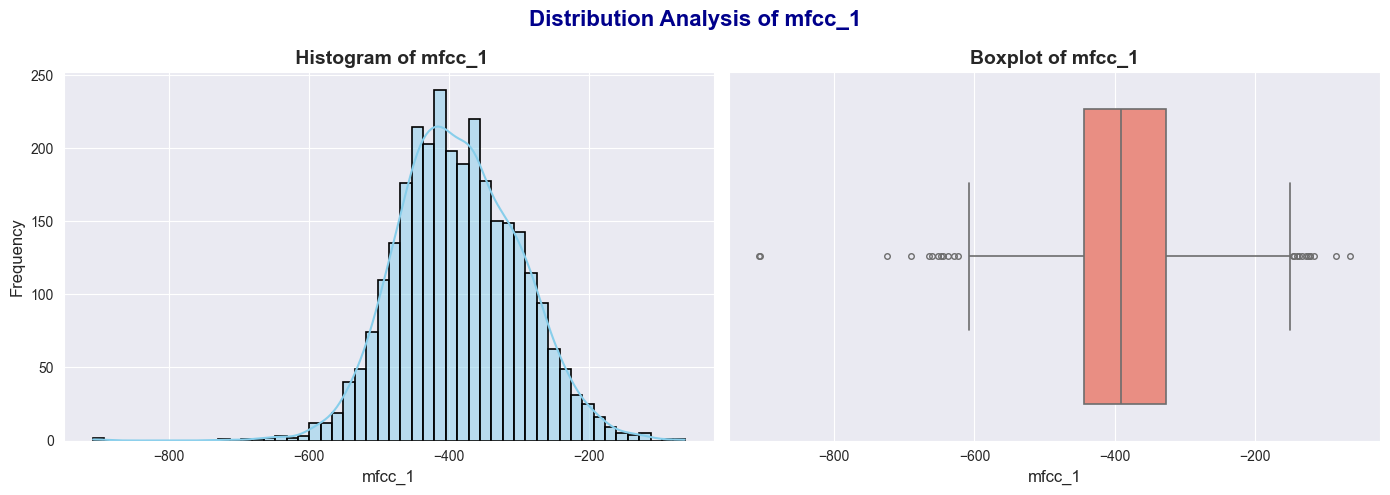

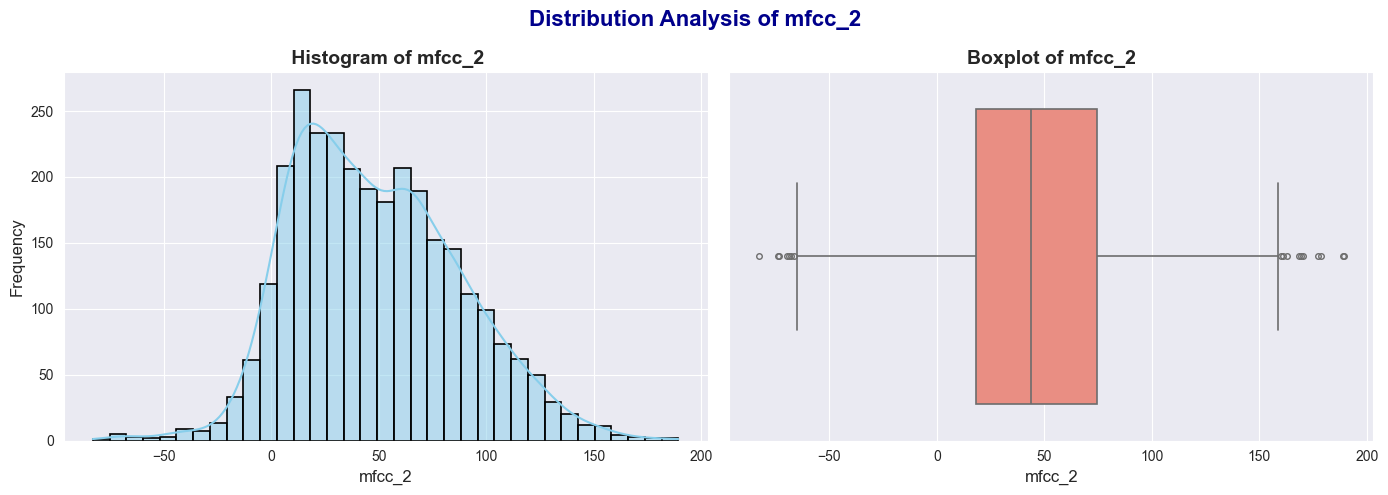

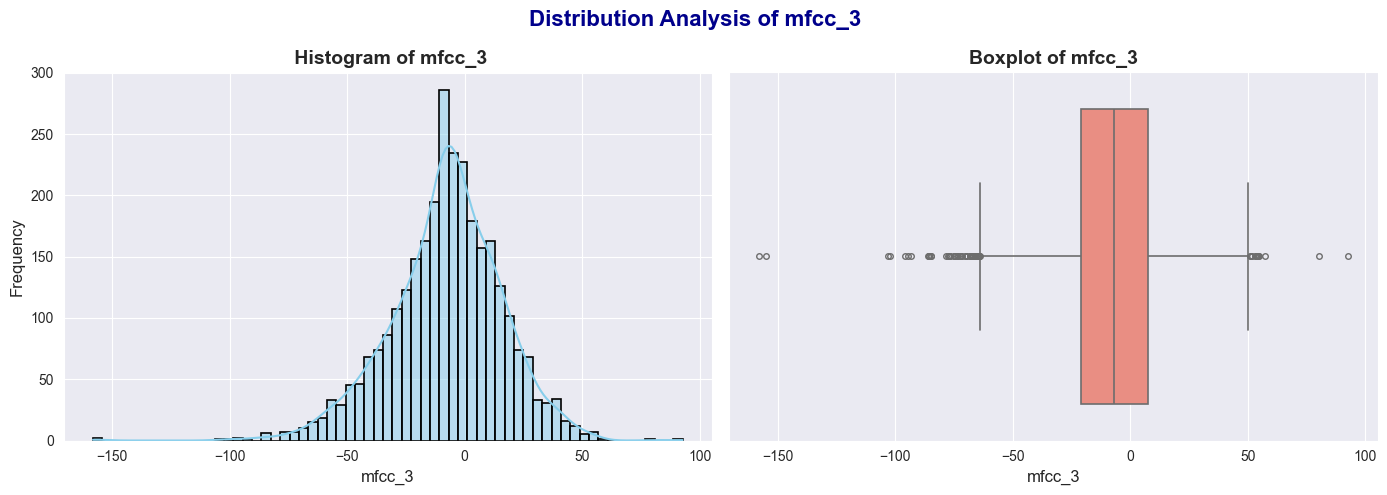

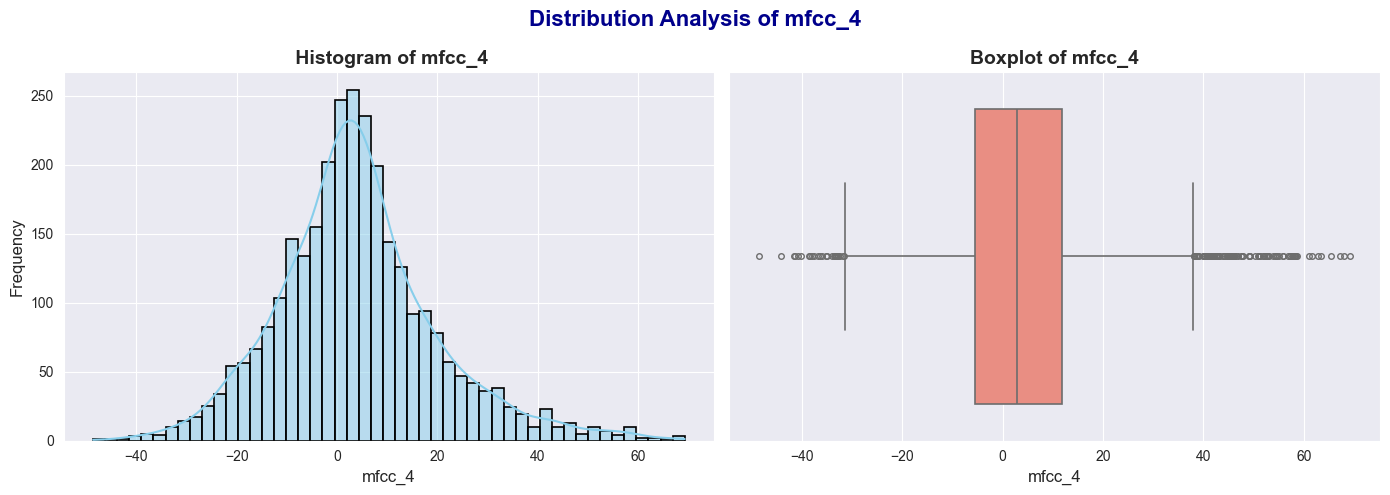

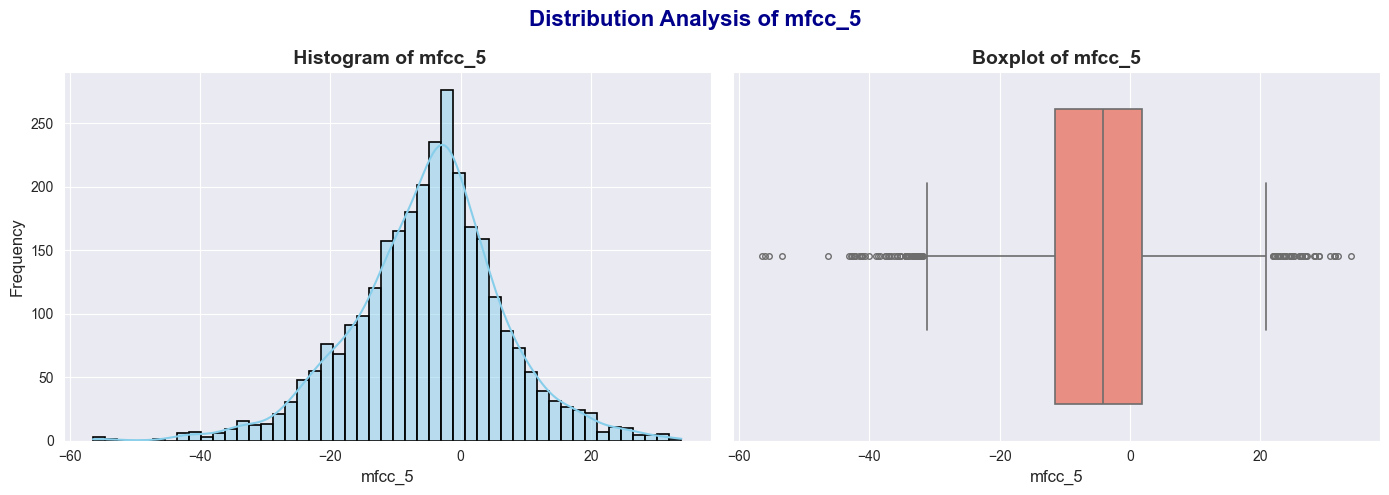

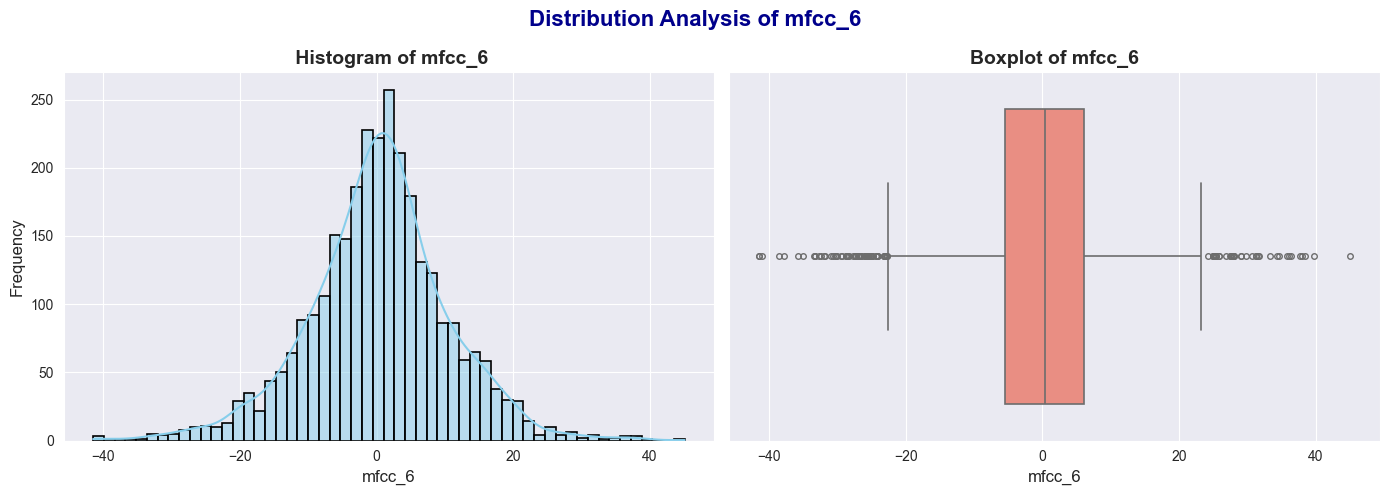

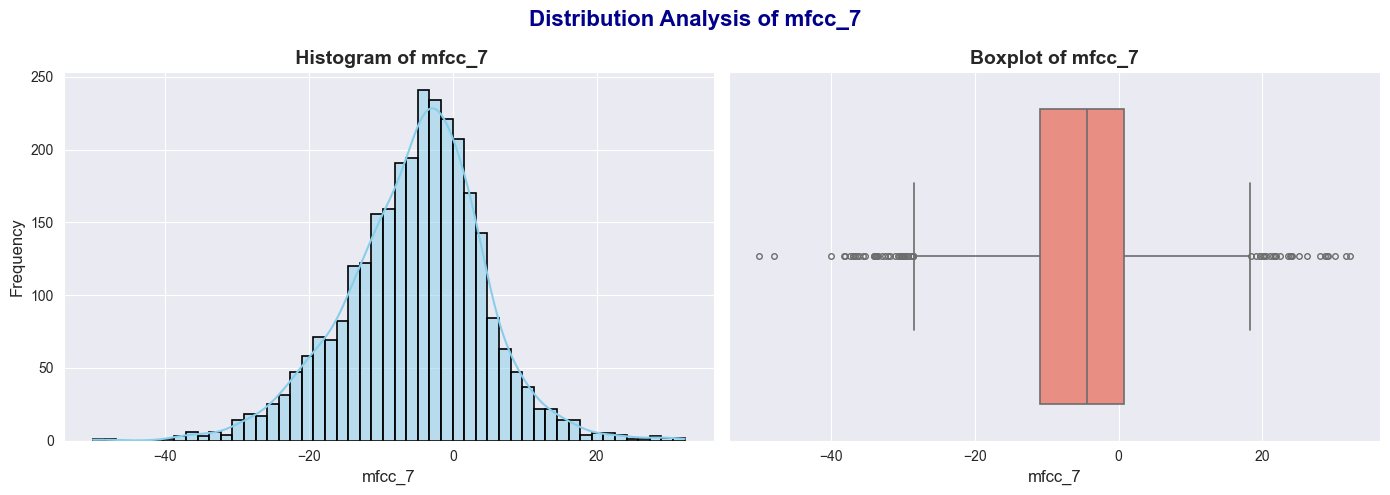

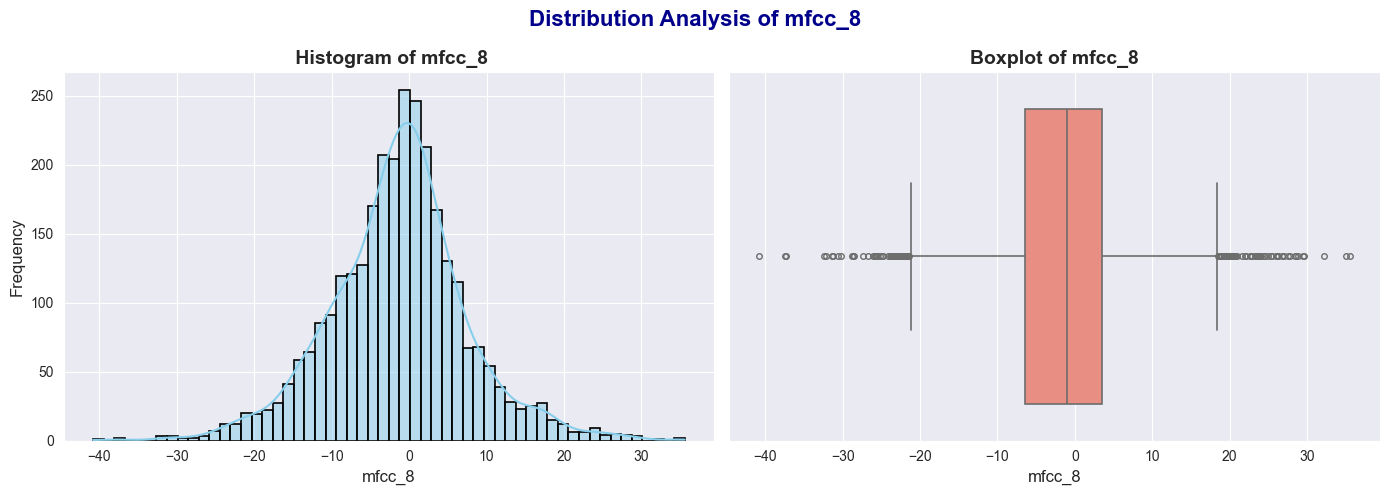

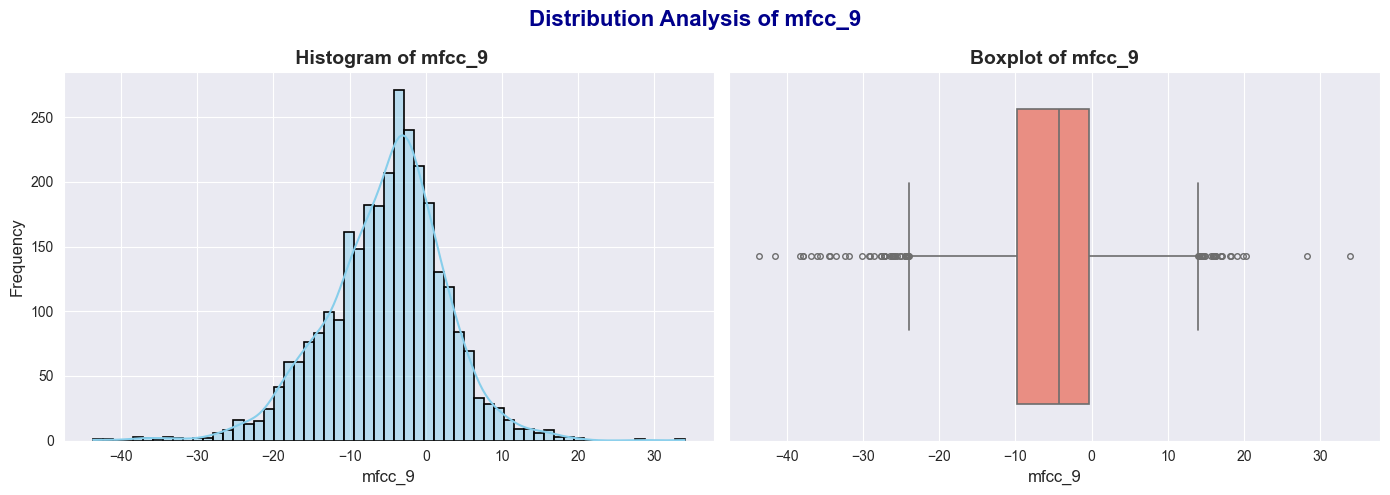

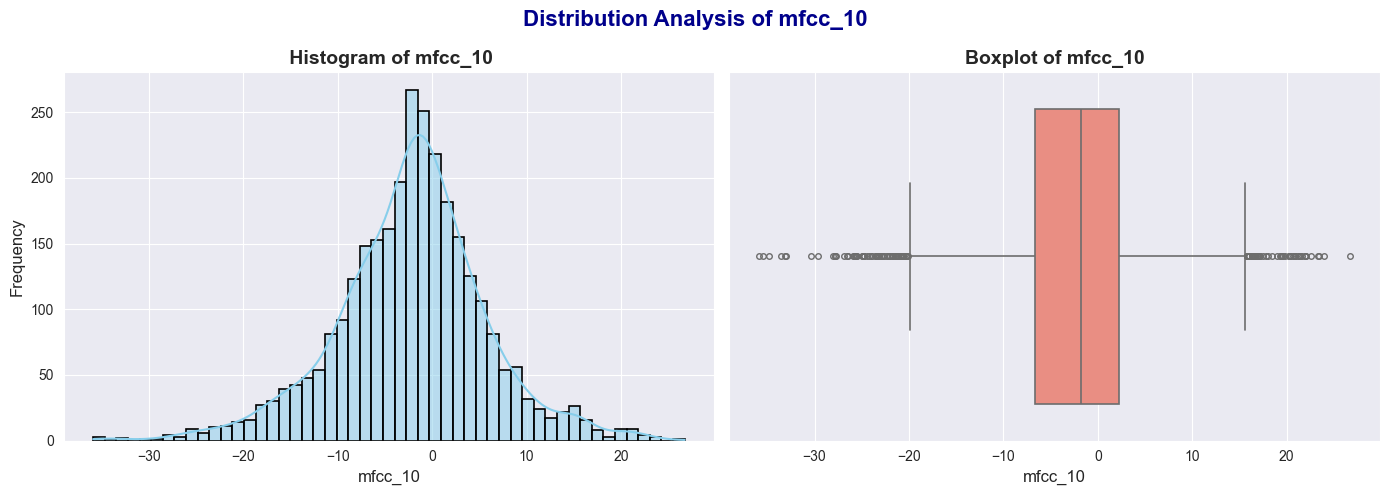

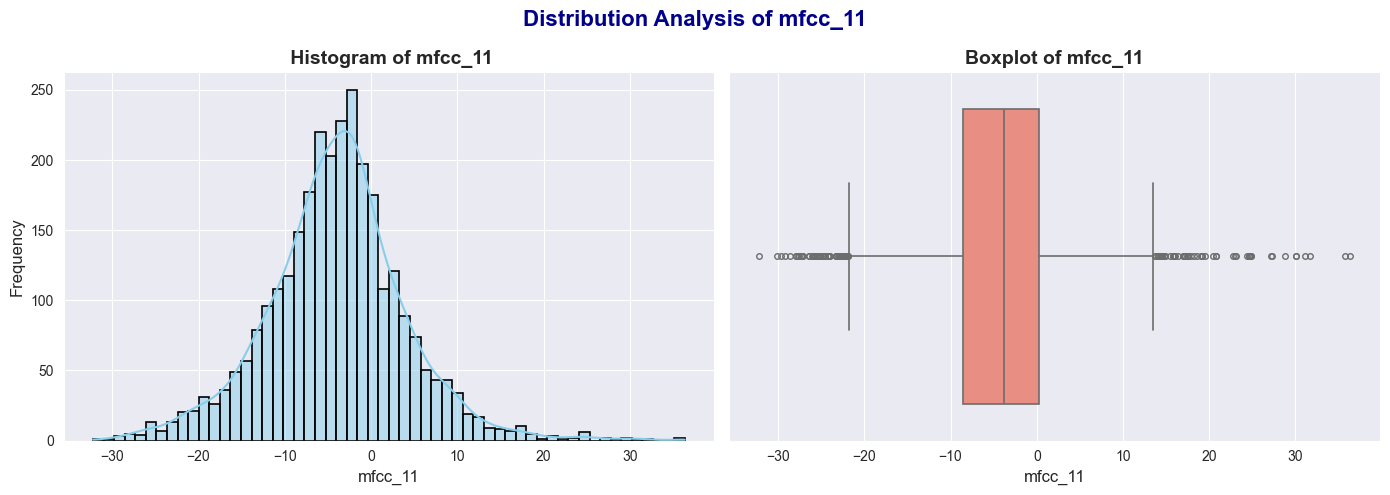

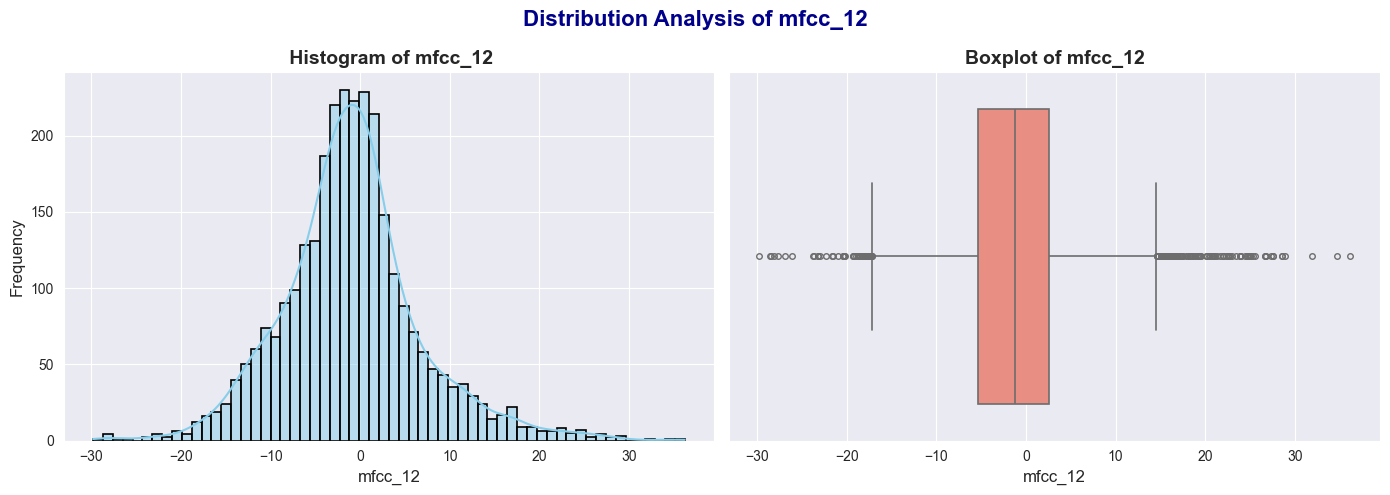

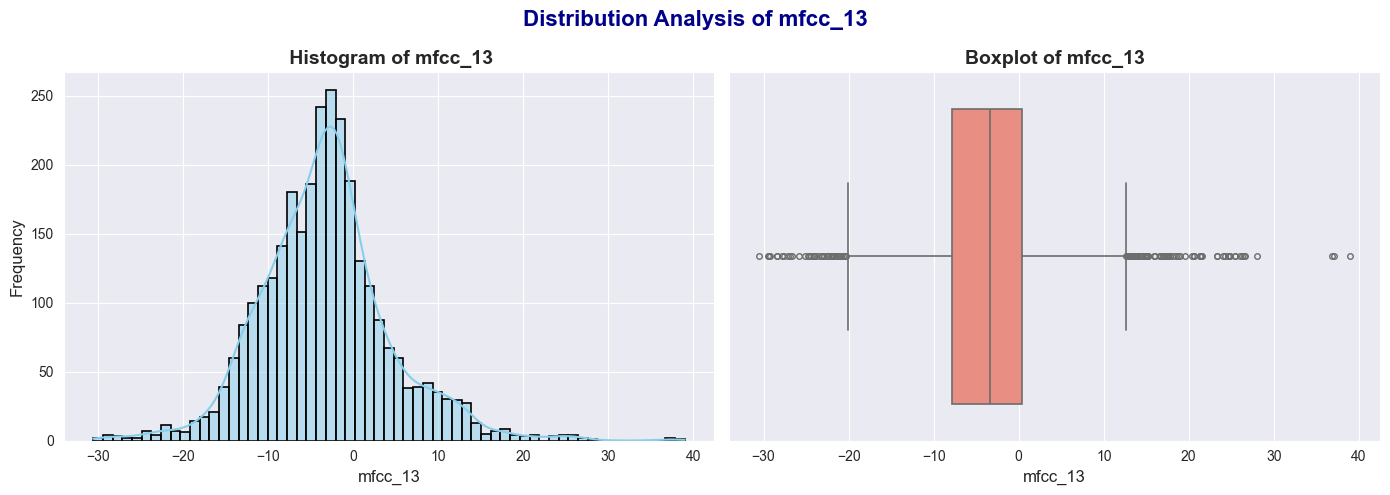

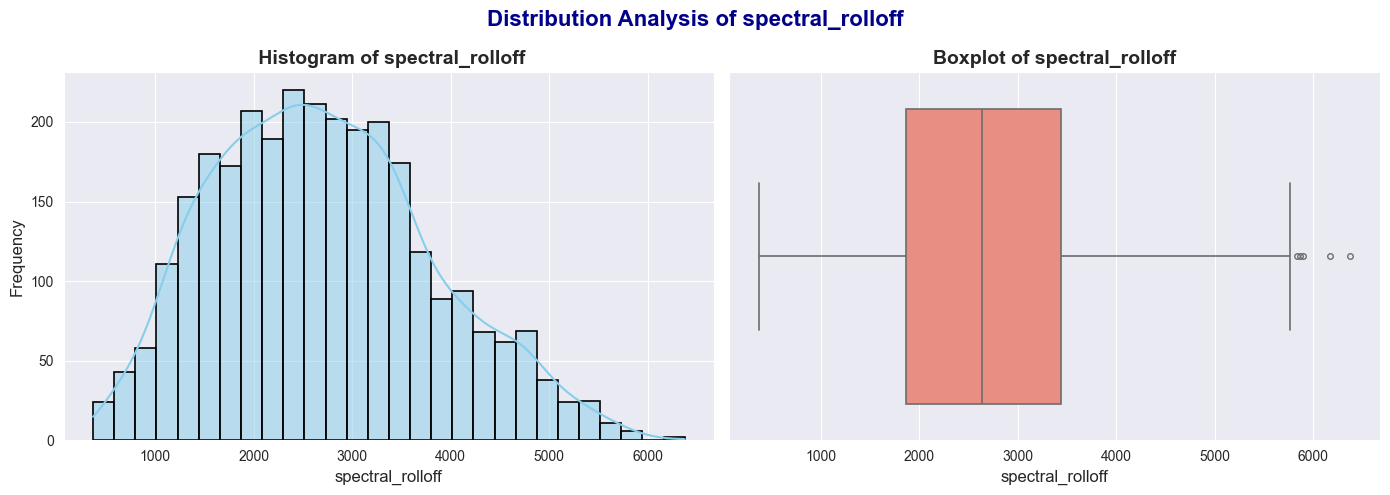

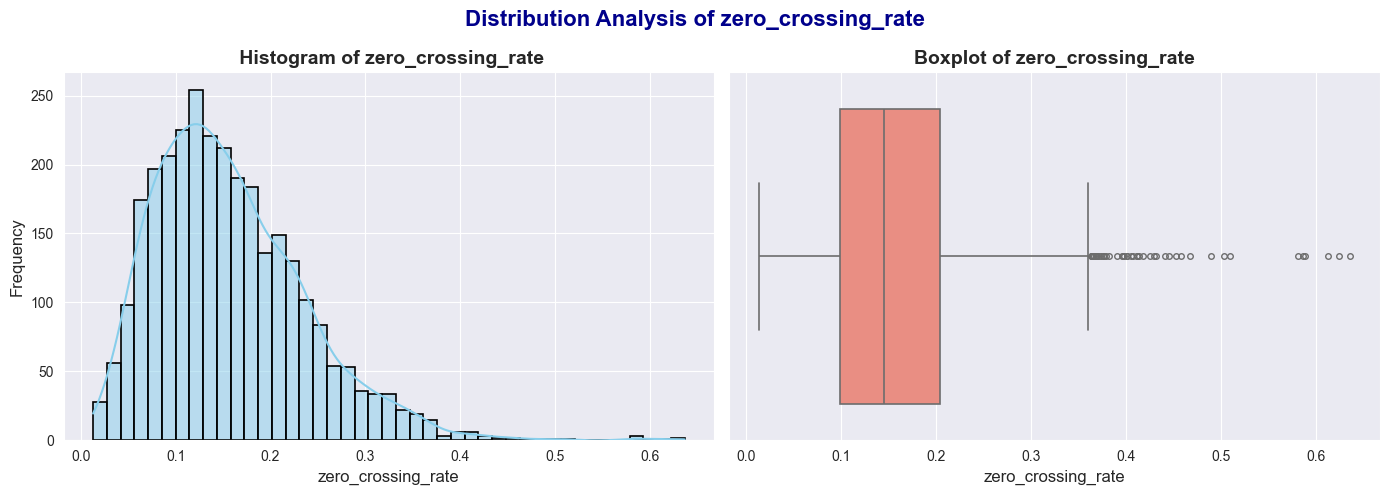

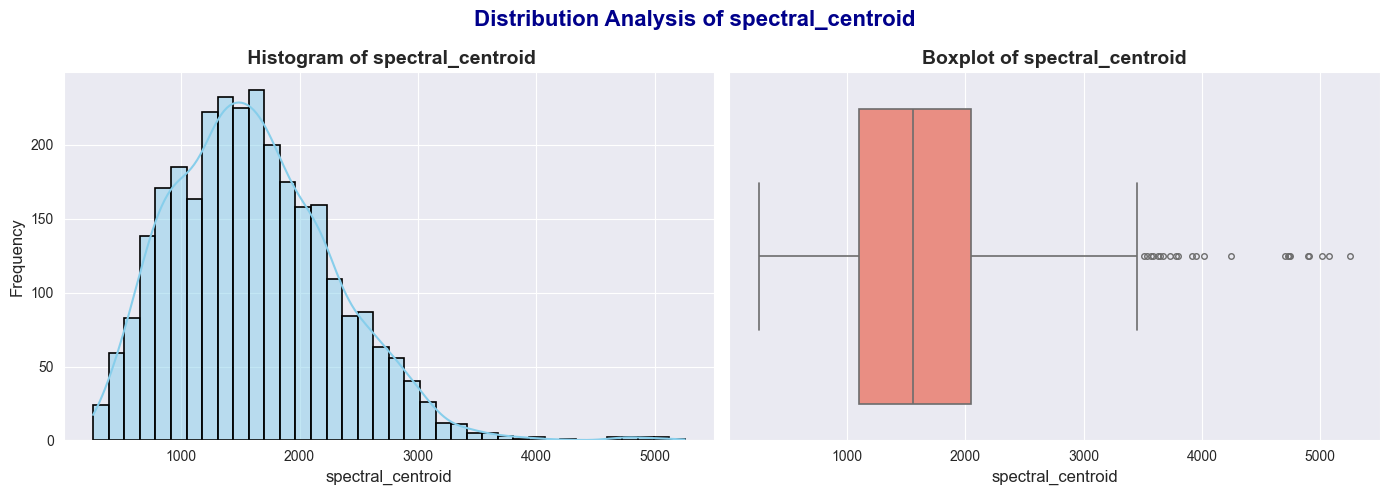

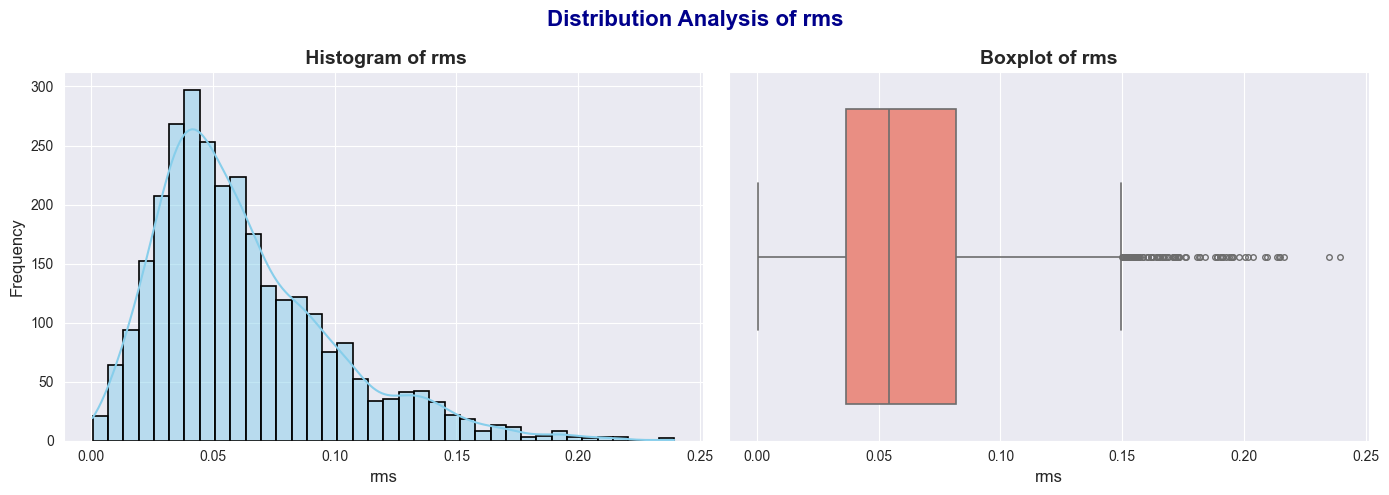

In [31]:
visula_numcol(df,num_cols)

In [32]:
def handle_outlier(df, num_cols, strategy='replace'):
 outlier_report = []
 for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        n_outliers = outliers.shape[0]

        outlier_report.append({
            'column': col,
            'outliers_found': n_outliers,
            'lower_bound': lower,
            'upper_bound': upper
        })

        if strategy == 'replace':
            median = df[col].median()
            df[col] = np.where((df[col] < lower) | (df[col] > upper), median, df[col])

        elif strategy == 'remove':
            df = df[~((df[col] < lower) | (df[col] > upper))]

 report_df = pd.DataFrame(outlier_report)
 return  report_df

In [33]:
handle_outlier(df,num_cols)

,column,outliers_found,lower_bound,upper_bound
0,mfcc_1,24,-621.358932,-148.687912
1,mfcc_2,17,-66.095546,159.127652
2,mfcc_3,58,-64.101477,50.737472
3,mfcc_4,127,-31.713322,37.994877
4,mfcc_5,101,-31.486417,21.842973
5,mfcc_6,98,-22.658058,23.237694
6,mfcc_7,69,-28.505758,18.417741
7,mfcc_8,112,-21.372504,18.354150
8,mfcc_9,73,-23.971163,13.930296
9,mfcc_10,118,-19.959827,15.623978


In [34]:
round(df['dog_emotion'].value_counts(normalize=True)*100,2)

dog_emotion
angry       20.37
Resting     20.10
happy       20.10
Stressed    19.76
Sad         19.66
Name: proportion, dtype: float64

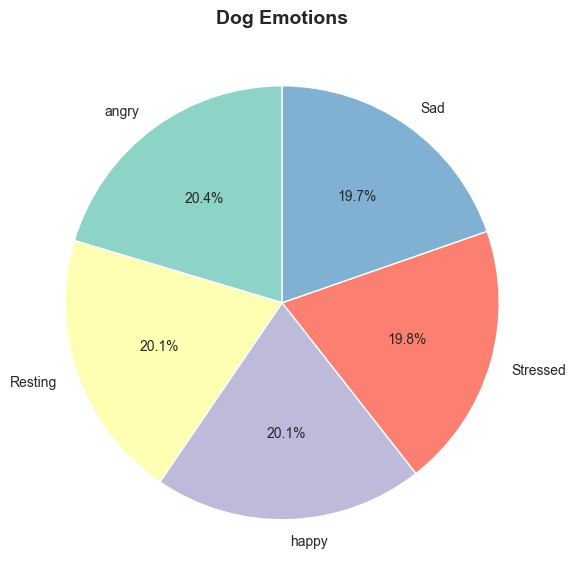

In [35]:
counts = df['dog_emotion'].value_counts()
plt.figure(figsize=(7,10))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Set3.colors
)
plt.title("Dog Emotions", fontsize=14, weight="bold")
plt.show()

## **There is a clear imbalance problem.**

In [36]:
le=LabelEncoder()
df['dog_emotion']=le.fit_transform(df['dog_emotion'])

In [37]:
X = df.drop('dog_emotion', axis=1)
y = df['dog_emotion']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

estimators = [
    ("xgb", XGBClassifier(eval_metric="mlogloss", random_state=42)),
    ("lgbm", LGBMClassifier(random_state=42)),
    ("cat", CatBoostClassifier(verbose=0, random_state=42))
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5, n_jobs=-1
)

Stacking Test Accuracy: 0.8370118845500849
Stacking Training Accuracy: 1.0
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       119
           1       0.75      0.84      0.79       116
           2       0.88      0.83      0.85       116
           3       0.85      0.88      0.87       120
           4       0.80      0.69      0.75       118

    accuracy                           0.84       589
   macro avg       0.84      0.84      0.84       589
weighted avg       0.84      0.84      0.84       589



<Axes: >

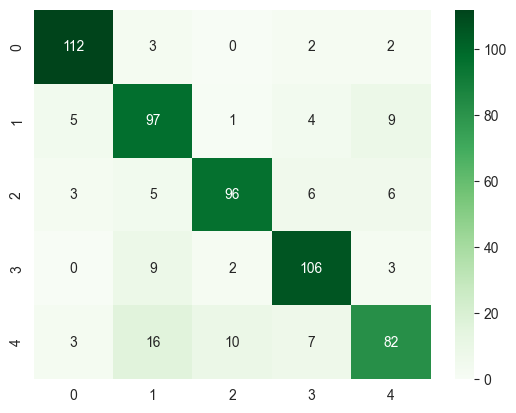

In [41]:
stack_model.fit(X_train_scaled, y_train)
print("Stacking Test Accuracy:", stack_model.score(X_test_scaled, y_test))
print("Stacking Training Accuracy:", stack_model.score(X_train_scaled, y_train))
print(classification_report(y_test, stack_model.predict(X_test_scaled)))
sns.heatmap(confusion_matrix(y_test, stack_model.predict(X_test_scaled)), annot=True, fmt='d', cmap='Greens')

In [42]:
import joblib
joblib.dump(stack_model, 'Cat_emotion_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']